# Модель предсказания цен на недвижимость для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

https://www.kaggle.com/c/realestatepriceprediction

In [144]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.spatial.distance import cdist

from lightgbm import LGBMRegressor

%matplotlib inline

In [145]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [146]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

# 1. Чтение данных

In [208]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


7943

In [209]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. EDA

### 1.1 Выбросы

In [304]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [305]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [306]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [307]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [308]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [309]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [310]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [311]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [693]:
X[X['KitchenSquare'] > X['Square']]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor_outlier,LifeSquare_nan,HouseFloor,HouseYear,DistrictId_count,Shops_2,MedPriceByDistrict,MedPriceByFloorYear,Ecology_component_1,Social_component_1,Life_square_cat
2916,3.0,52.51331,99.323558,96.0,22.0,0.210473,11,0,0,0,25.0,2019,5.0,1,184648.563531,188165.724131,0.001007,-2954.191162,5.0
8232,2.0,52.51331,57.510395,54.0,25.0,0.069753,53,11,1,0,25.0,2016,111.0,1,262469.686211,188165.724131,-0.040961,8317.885706,5.0
9895,3.0,52.51331,125.806981,123.0,5.0,0.017647,2,0,0,0,10.0,2015,851.0,1,213530.788443,155089.912971,-0.056501,-4883.212622,5.0


### Заполнение NaN

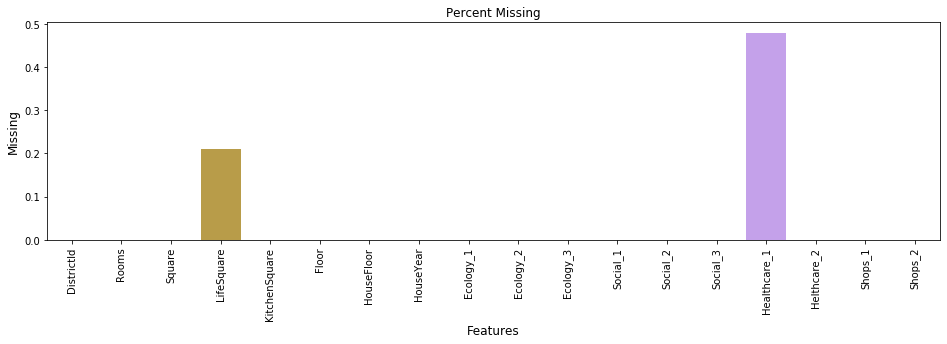

In [312]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

In [1404]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


### 1.2 Feature engineering

**DistrictId**

In [209]:
X.DistrictId.nunique()

205

In [210]:
dict(X['DistrictId'].value_counts())

{27: 851,
 1: 652,
 23: 565,
 6: 511,
 9: 294,
 62: 247,
 30: 228,
 58: 179,
 53: 174,
 21: 165,
 52: 143,
 8: 142,
 11: 129,
 46: 119,
 61: 118,
 45: 116,
 74: 114,
 34: 111,
 57: 107,
 44: 104,
 99: 97,
 101: 97,
 47: 97,
 13: 97,
 7: 92,
 48: 90,
 29: 89,
 94: 89,
 41: 87,
 3: 82,
 84: 80,
 28: 79,
 2: 78,
 22: 78,
 25: 77,
 85: 76,
 93: 73,
 37: 72,
 90: 72,
 96: 71,
 59: 67,
 75: 66,
 26: 65,
 12: 64,
 88: 64,
 128: 64,
 66: 62,
 67: 61,
 17: 59,
 55: 58,
 39: 57,
 10: 56,
 105: 55,
 31: 55,
 18: 51,
 111: 49,
 119: 49,
 0: 48,
 78: 46,
 91: 44,
 124: 43,
 63: 43,
 129: 43,
 42: 42,
 79: 42,
 109: 41,
 113: 41,
 77: 40,
 54: 37,
 15: 36,
 38: 36,
 24: 35,
 5: 34,
 56: 34,
 32: 34,
 103: 33,
 123: 32,
 19: 31,
 80: 31,
 33: 31,
 83: 31,
 69: 29,
 138: 29,
 130: 29,
 64: 28,
 108: 27,
 86: 27,
 70: 27,
 87: 27,
 120: 26,
 122: 25,
 100: 25,
 121: 25,
 20: 24,
 89: 24,
 107: 23,
 35: 22,
 169: 22,
 98: 21,
 167: 20,
 144: 20,
 145: 19,
 146: 18,
 81: 18,
 134: 18,
 73: 17,
 36: 17,
 

# 2. Очистка данных

In [210]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['Square'] > 1000, 'KitchenSquare'] / 10
        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = X['KitchenSquare'].median()
        X['KitchenSquare'] = X['KitchenSquare'].fillna(X['KitchenSquare'].median())
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        #LifeSquare
        
        X.loc[X['LifeSquare'] > X['Square'], 'Square'] = X['LifeSquare']+X['KitchenSquare']+3
        X.loc[X['LifeSquare']>1000, 'LifeSquare'] = X['LifeSquare'].median()
        X.loc[X['Square']<10, 'Square'] = X['Square'].median()
        
        X.loc[X['Square']>1000, 'Square'] = X['Square'].median()
        X.loc[X['LifeSquare']>X['Square'], 'Square1']= X['Square']
        X.loc[X['LifeSquare']>X['Square'], 'Square']= X['LifeSquare']
        X.loc[X['Square1']>0, 'LifeSquare']= X['Square1']
        X = X.drop('Square1', axis=1)
    
        X.loc[X['KitchenSquare']+X['LifeSquare']>X['Square'], 'Square'] = X['KitchenSquare']+X['LifeSquare']
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [211]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# 3. Feature engineering

In [212]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X.replace({'Ecology_3': 
            {6.0 : X['Ecology_3'].mode()[0],
            32.772431056458856 : X['Ecology_3'].mode()[0]}
           }, inplace=True)
        X.replace({'Ecology_2': 
            {6.0 : X['Ecology_2'].mode()[0],
            32.772431056458856 : X['Ecology_2'].mode()[0]}
           }, inplace=True)
        X.replace({'Shops_2': 
            {6.0 : X['Shops_2'].mode()[0],
            32.772431056458856 : X['Shops_2'].mode()[0]}
           }, inplace=True)
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X_ecology = X[['Ecology_1', 'Ecology_2', 'Ecology_3']]
        pca = PCA(n_components=1, random_state=42)
        X['Ecology_component_1'] = pca.fit_transform(X_ecology)
        
        
        X_social = X[['Social_1', 'Social_2', 'Social_3']]
        pca = PCA(n_components=1, random_state=42)
        X['Social_component_1'] = pca.fit_transform(X_social)
        
        X_square = X[['Square', 'LifeSquare', 'KitchenSquare']]
        pca = PCA(n_components=1, random_state=42)
        X['Square_component_1'] = pca.fit_transform(X_square)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.square_to_cat(X)
        X = self.square_floor(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
        
        return X 
    
    @staticmethod
    def square_to_cat(X):
        
        X['Life_square_cat'] = np.nan
        
        X.loc[X['LifeSquare'] < 5, 'Life_square_cat'] = 1
        X.loc[(X['LifeSquare'] >= 5) & (X['LifeSquare'] <= 10), 'Life_square_cat'] = 2
        X.loc[(X['LifeSquare'] > 10) & (X['LifeSquare'] <= 20), 'Life_square_cat'] = 3
        X.loc[(X['LifeSquare'] > 20) & (X['LifeSquare'] <= 40), 'Life_square_cat'] = 4
        X.loc[(X['LifeSquare'] > 40) & (X['LifeSquare'] <= 60), 'Life_square_cat'] = 5
        X.loc[(X['LifeSquare'] > 60), 'Life_square_cat'] = 6
        
        return X
    
    @staticmethod
    def square_floor(X):
        
        X['square_floor'] = X['Square'] * X['Floor']
        
        

        return X

In [213]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [214]:
medianMP = X['MedPriceByDistrict'].median()
X['MedPriceByDistrict'] = X['MedPriceByDistrict'].fillna(medianMP)
X_final['MedPriceByDistrict'] = X_final['MedPriceByDistrict'].fillna(medianMP)
medianFY = X['MedPriceByFloorYear'].median()
X['MedPriceByFloorYear'] = X['MedPriceByFloorYear'].fillna(medianFY)
X_final['MedPriceByFloorYear'] = X_final['MedPriceByFloorYear'].fillna(medianFY)

In [215]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
colnames = X.columns
X = pd.DataFrame(scaler.fit_transform(X), columns=colnames)
X_final = pd.DataFrame(scaler.transform(X_final), columns=colnames) # НЕ обучаемся на тесте!

In [ ]:
apply_elbow_method(np.array(X).reshape(-1, 1))

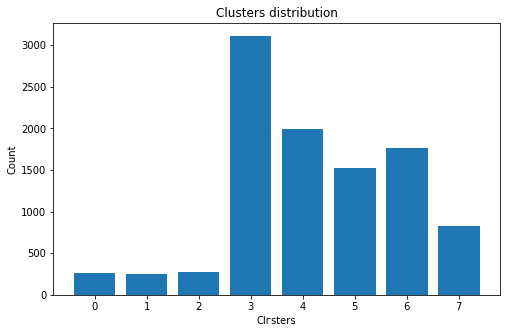

In [216]:
kmeans_8 = KMeans(n_clusters=8, random_state=42)
labels_clast_8 = kmeans_8.fit_predict(X)
labels_clast_8 = pd.Series(labels_clast_8, name='clusters_8')

unique, counts = np.unique(labels_clast_8, return_counts=True)
display_clusters_distribution(unique, counts)

In [217]:
clusters_8_dummies = pd.get_dummies(labels_clast_8, drop_first=False, prefix='clusters_8')
labels_clast_8_final = kmeans_8.predict(X_final)
clusters_8_dummies_final = pd.get_dummies(labels_clast_8_final, drop_first=False, prefix='clusters_8')
X = pd.concat([X, clusters_8_dummies], 
                   axis=1)
X_final = pd.concat([X_final, clusters_8_dummies_final], 
                   axis=1)

In [218]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                   'HouseFloor_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear', 'Ecology_component_1', 'Social_component_1', 
                   'clusters_8_0', 'clusters_8_1',
                   'clusters_8_3','clusters_8_5', 'clusters_8_6', 'clusters_8_7', 'Square_component_1']

X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

### Определение гиперпараметров модели

In [439]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [440]:
parameters = {
    'n_estimators': [150, 200, 250, 300],
    'min_samples_leaf': np.arange(5, 20),
    'max_depth': np.arange(5, 20)
}

clf = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [ ]:
clf.fit(X, y)

In [136]:
clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 250}

In [219]:
model = LGBMRegressor(max_depth=20,
                             min_samples_leaf=50,
                             n_estimators=250, #250
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.743 +- 0.016


In [220]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=50,
              min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

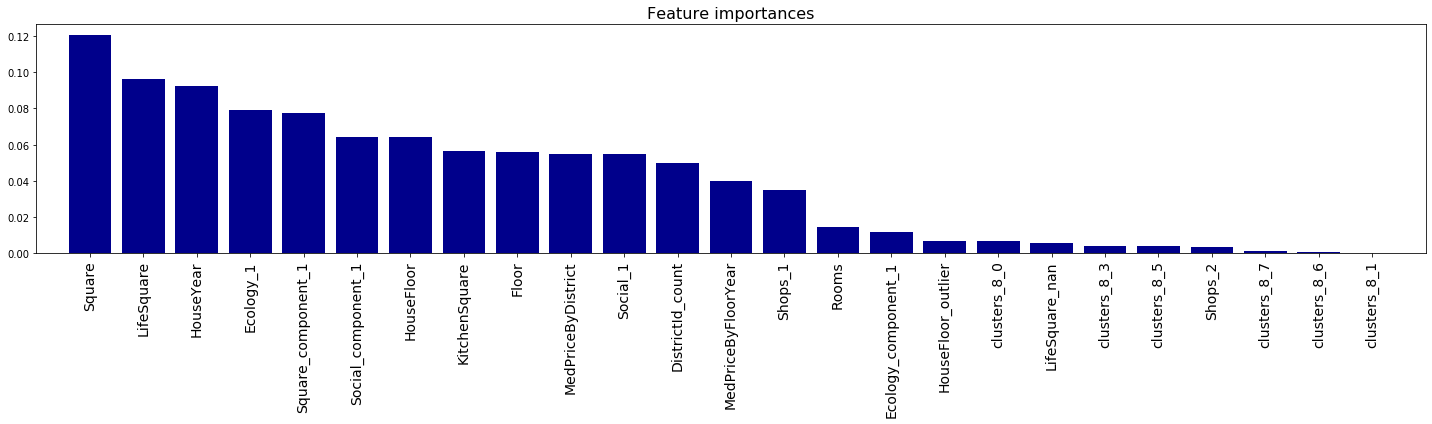

In [221]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [222]:
y_pred_final = model.predict(X_final)

# preds_final = pd.DataFrame()
# preds_final['Id'] = X_final.index
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,150843.718929
1,15856,243007.928227
2,5480,184111.171828
3,15664,324884.061959
4,14275,136971.233667
